# CS 634 - Final Term Project
**Name:** Srushti Thakre  
**ID:** 31667303  
**Course:** Data Mining <br>
**Instructor:** Dr. Yasser Abduallah


## 1. Introduction  
Human Activity Recognition (HAR) aims to automatically detect physical activities such as walking, standing, jogging, or climbing stairs using data directly collected from smartphone sensors. With the rise of wearable devices and mobile sensing technologies, HAR has become a crucial component in applications related to:
- Health monitoring  
- Fitness tracking  
- Behavior analysis  
- Smart homes  
- Human-computer interaction  

In this project, I have used the **WISDM (Wireless Sensor Data Mining)** dataset to classify activities into Moving vs Stationary using smartphone accelerometer data. The goal is to evaluate and compare the performance of:
1. **Random Forest (RF)**  
2. **Support Vector Machine with RBF Kernel (SVM)**  
3. **Gated Recurrent Unit (GRU)** neural network  


To ensure fairness and avoid user-specific leakage, I use a GroupKFold cross-validation strategy, where each fold corresponds to a unique user.  
Model performance is assessed using multiple metrics, including Accuracy, Balanced Accuracy, Precision, Recall, F1-score, AUC, TSS, and HSS.  
Finally, ROC curves are visualized to compare threshold-independent model performance.

## 2. Environment and Required Libraries

To ensure reproducibility, the Python environment details are printed below:

In [33]:
import sys, platform
print("Python version:", platform.python_version())
print("Interpreter path:", sys.executable)

Python version: 3.12.6
Interpreter path: C:\Users\thakr\Documents\finaltermproject\.venv\Scripts\python.exe


### 2.1 Importing Required Libraries

The following libraries are used for data loading, preprocessing, visualization, and evaluation of machine learning models.

In [34]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configure plots
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# ML Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, brier_score_loss
)

# For group-based cross-validation
from sklearn.model_selection import GroupKFold


### 2.2 Project Paths

All files (CSV, ROC curves, per-fold results) are stored in structured project folders.

In [35]:
DATA_PATH = "data/WISDM_raw.csv"
RESULTS_DIR = "results"

## 3. Dataset Description (WISDM)
The WISDM Smartphone and Smartwatch dataset contains accelerometer and gyroscope readings collected from 51 subjects performing various daily-life activities.
### Sensor Used  
- Smartphone accelerometer (20 Hz sample rate)
### Activities Included  
- Walking, Jogging, Upstairs, Downstairs  
- Sitting, Standing, Typing, Writing  
- Drinking, Eating, Clapping, Brushing Teeth  (and several others)
### Data Preparation  
To keep computation manageable for this project:
- Selected **10 users** from the dataset  
- Performed temporal downsampling using `every_k = 100`  
- Used the provided script `build_wisdm_raw_csv.py` to generate a trimmed dataset  
- Final dataset: `data/WISDM_raw.csv`

This dataset contains the following fields:
- `user`
- `activity`
- `timestamp`
- `ax`, `ay`, `az` (accelerometer axes)

A binary label was created:
- **Moving** = {Walking, Jogging, Upstairs, Downstairs, Running}  
- **Stationary** = {Sitting, Standing, Typing, Writing, Clapping, BrushingTeeth, EatingSoup, EatingChips, EatingPasta, EatingSandwich, Drinking}
    

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

DATA_PATH = "data/WISDM_raw.csv"
RESULTS_DIR = "results"


### Inspecting the Loaded Dataset

Before starting any preprocessing or modeling, it must be verified that the WISDM dataset was loaded correctly. 
To do this, `df.head()` is used which shows the first five rows of the dataframe. Since the dataset is recorded from continuous sensor readings,
the first few rows almost always belong to the same activity (in this case, *Downstairs*). This is expected because the dataset is time-ordered and all samples from the same recording session appear consecutively.

In [37]:
df = pd.read_csv(DATA_PATH)
df.head()

,user,activity,timestamp,ax,ay,az
0,1600,Downstairs,2.416027e+14,3.975113,4.524292,6.984695
1,1600,Downstairs,2.416077e+14,4.033554,4.607468,6.900696
2,1600,Downstairs,2.416128e+14,4.115295,4.662262,6.765427
3,1600,Downstairs,2.416178e+14,4.171875,4.739700,6.700165
4,1600,Downstairs,2.416228e+14,4.154404,4.628326,6.728500


However, `df.head()` alone does not reflect the full variety of activities present in the dataset. To confirm that all 18 activities 
were successfully loaded, a small summary table is displayed that selects one example row per
activity as shown below:

In [38]:
# one example row for each activity
examples_per_activity = (
    df.groupby("activity")
      .head(1)                 # take first row of each activity
      .sort_values("activity") # sort by activity name
      .reset_index(drop=True)
)

examples_per_activity[["user", "activity", "timestamp", "ax", "ay", "az"]]


,user,activity,timestamp,ax,ay,az
0,1600,BrushingTeeth,2.537162e+14,1.729416,7.788513,5.052353
1,1600,Clapping,2.443291e+14,-1.488525,9.683563,0.295975
2,1600,Downstairs,2.416027e+14,3.975113,4.524292,6.984695
3,1600,Dribbling,2.450105e+14,2.245316,8.433060,3.720276
4,1600,Drinking,2.512332e+14,1.247681,7.579788,5.426285
5,1600,EatingChips,2.539462e+14,2.475418,6.773041,5.801209
6,1600,EatingPasta,2.430718e+14,1.389465,6.302322,6.630081
7,1600,EatingSandwich,2.525426e+14,-1.473068,9.586395,0.551193
8,1600,EatingSoup,2.456942e+14,2.952530,6.874908,5.559952
9,1600,Jogging,2.519889e+14,-2.171036,6.407791,0.867966


## 4. Dataset Overview

After loading the processed WISDM CSV file that was generated using the build_wisdm_raw_csv.py script, firstly the basic structure
of the dataset needs to be checked. The table contains six columns: the user ID, activity label, timestamp, and the three accelerometer axes (ax, ay, az).

To understand what I am working with, the shape of the dataset was looked at, checked for any missing values, and inspected how the 
activities are distributed. Since this CSV is already filtered to only include the selected users and downsampled using the script 
parameters, the dataset is much smaller than the full WISDM dataset. This makes it easier to run 10-fold cross validation without extremely
long runtimes.

I also checked how many unique users are present because my cross-validation later depends on GroupKFold, which splits data by user. 
The number of users must be at least equal to the number of folds (10), so confirming this here is important.

In [39]:
# Basic exploration of the WISDM dataset
print("Shape of the dataset:", df.shape)

print("\nNumber of missing values in each column:")
display(df.isna().sum())

print("\nDistribution of activities:")
display(df['activity'].value_counts())

print("\nNumber of unique users:", df['user'].nunique())

Shape of the dataset: (7576, 6)

Number of missing values in each column:


user         0
activity     0
timestamp    0
ax           0
ay           0
az           0
dtype: int64


Distribution of activities:


activity
EatingSandwich    455
Walking           454
PlayingCatch      449
Kicking           449
Drinking          447
BrushingTeeth     446
EatingPasta       443
EatingSoup        440
Jogging           413
Clapping          406
EatingChips       405
Dribbling         397
Upstairs          396
Sitting           396
Typing            396
Standing          395
Writing           395
Downstairs        394
Name: count, dtype: int64


Number of unique users: 10


## 5. Creating the Binary Target Variable

The original WISDM dataset contains many different activity labels (Walking, Jogging, Sitting, Typing, etc.).  
For this project we are not trying to predict each individual activity. Instead, we collapse them into a simple binary problem:

- **Moving (label = 1)** => Walking, Jogging, Upstairs, Downstairs, Running  
- **Stationary (label = 0)** => Sitting, Standing, Typing, Writing, Clapping, Drinking, and all the eating activities

The function `to_bin()` follows the same logic that we used inside the `run_wisdm_cv.py` script.  
Here in the notebook we recreate it just to show clearly how the labels are derived from the original activity names.  
This new column is stored as `df["y"]` and will be the target variable for all three models.


In [40]:
# Define the same moving / stationary sets that were used in run_wisdm_cv.py
moving = {"Walking", "Jogging", "Upstairs", "Downstairs", "Running"}
stationary = {
    "Sitting", "Standing", "Typing", "Writing", "Clapping",
    "Drinking", "EatingSoup", "EatingChips", "EatingPasta",
    "EatingSandwich", "BrushingTeeth"
}

def to_bin(a):
    if a in moving:
        return 1
    if a in stationary:
        return 0
    # anything unexpected just map to 0 (stationary) by default
    return 0

# Create the binary target column y
df["y"] = df["activity"].astype(str).map(to_bin).astype(int)

df[["activity", "y"]].head(10)


,activity,y
0,Downstairs,1
1,Downstairs,1
2,Downstairs,1
3,Downstairs,1
4,Downstairs,1
5,Downstairs,1
6,Downstairs,1
7,Downstairs,1
8,Downstairs,1
9,Downstairs,1


In [41]:
# Check distribution of the binary target y
class_counts = df["y"].value_counts().rename(index={0: "Stationary (0)", 1: "Moving (1)"})
class_counts

y
Stationary (0)    5919
Moving (1)        1657
Name: count, dtype: int64

## 6. Class distribution (moving vs stationary)

After mapping the original activity names to a binary label `y`, how many samples fall into each class was checked.  
The bar chart shows that there are more stationary windows than moving ones.  

This imbalance is important because a classifier could get high accuracy by mostly predicting the majority class, so in later sections we'll also  
look at metrics such as Balanced Accuracy, TSS, and HSS, which are more informative for imbalanced data.


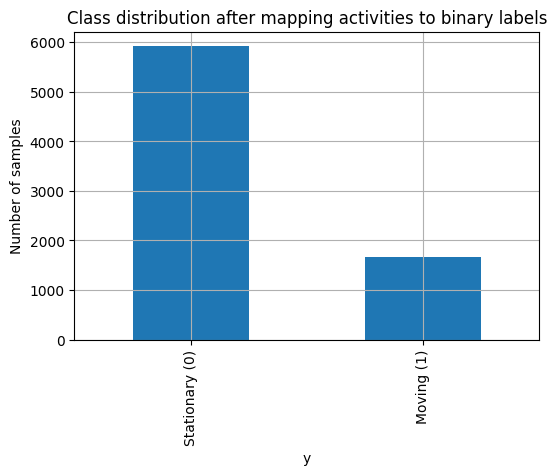

In [42]:
class_counts.plot(kind="bar")
plt.title("Class distribution after mapping activities to binary labels")
plt.ylabel("Number of samples")
plt.show()

## 7. Cross-validation summary

The table below is loaded directly from `results/summary_means.csv`.  
This file is generated by the `run_wisdm_cv.py` script.

For this project the models are evaluated using 10-fold GroupKFold, where each fold corresponds to a different user in the WISDM dataset.
This is important because sensor data from the same person is highly correlated. If we used a normal KFold split, data from the same user could appear in both the training and test sets, which would lead to data leakage and unrealistically high accuracy.

By grouping the data by user:<br>
- Each fold contains all data from exactly one user as the test set
- The remaining 9 users are used for training
- The model is therefore evaluated on a user it has never seen before
- This simulates real-world deployment, where the model must generalize to new unseen people

The script `run_wisdm_cv.py` trains all three models (Random Forest, SVM, GRU) on each of the 10 folds.
For every fold it computes a full set of metrics:
- Accuracy and Balanced Accuracy
- Precision, Recall, F1
- AUC (area under ROC curve)
- TSS and HSS (important for imbalanced binary classification)
- BS and BSS (Brier score metrics)

In [43]:
summary_path = os.path.join(RESULTS_DIR, "summary_means.csv")
summary = pd.read_csv(summary_path)
summary

,TP,TN,FP,FN,P,N,TPR,TNR,FPR,FNR,...,Recall,F1,ErrorRate,TSS,HSS,BS,BSS,AUC,Model,Fold
0,2.7,27.9,0.7,2.1,4.8,28.6,0.488333,0.976478,0.023522,0.511667,...,0.488333,0.495887,0.086938,0.464812,0.468350,0.066952,0.298949,0.902743,RandomForest,0
1,3.2,27.6,1.0,1.6,4.8,28.6,0.590000,0.966110,0.033890,0.410000,...,0.590000,0.558045,0.078372,0.556110,0.530997,0.067823,0.386958,0.888689,SVM,0
2,3.8,17.3,11.3,1.0,4.8,28.6,0.798333,0.587964,0.412036,0.201667,...,0.798333,0.347841,0.373199,0.386297,0.184922,0.201610,-0.800280,0.828452,GRU,0


After all 10 folds are evaluated, the script averages the values across folds and saves the results into "results/summary_means.csv"  

In [45]:
metrics = ["Accuracy", "BalancedAccuracy", "Precision", "Recall", "F1", "AUC", "BS", "BSS", "TSS", "HSS"]

summary_pretty = summary[["Model"] + metrics].copy()
summary_pretty[metrics] = summary_pretty[metrics].round(3)
summary_pretty

,Model,Accuracy,BalancedAccuracy,Precision,Recall,F1,AUC,BS,BSS,TSS,HSS
0,RandomForest,0.913,0.732,0.571,0.488,0.496,0.903,0.067,0.299,0.465,0.468
1,SVM,0.922,0.778,0.545,0.590,0.558,0.889,0.068,0.387,0.556,0.531
2,GRU,0.627,0.693,0.226,0.798,0.348,0.828,0.202,-0.800,0.386,0.185


## 8. Visual comparison of models

To compare the three models more easily, below plotted are the bar charts of a few key metrics.

* **Accuracy** - all models are reasonably accurate, but Random Forest and SVM are clearly better than the GRU on this dataset.
* **Balanced Accuracy** - SVM has the highest balanced accuracy, which means it handles the class imbalance between moving and stationary windows better.
* **F1 Score** - SVM again has the best trade-off between precision and recall.
* **AUC** - Random Forest achieves the highest AUC (around 0.90), so it is very good at ranking positive (moving) vs negative (stationary) windows.

Based on these averaged results, **SVM** proves to be best overall model, with Random Forest as a close second.  
The GRU performs worse here, which is reasonable because the dataset is relatively small for a deep neural network and the positive class is under-represented.


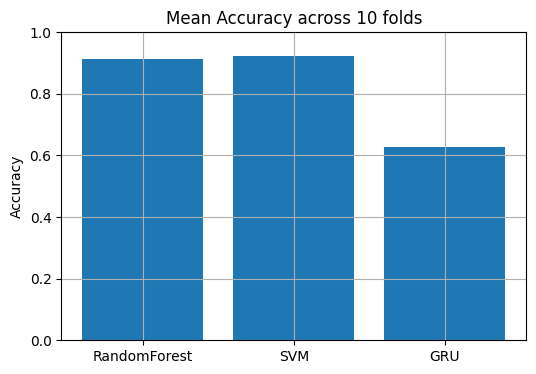

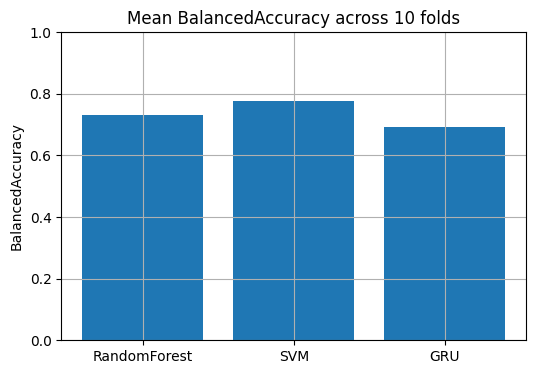

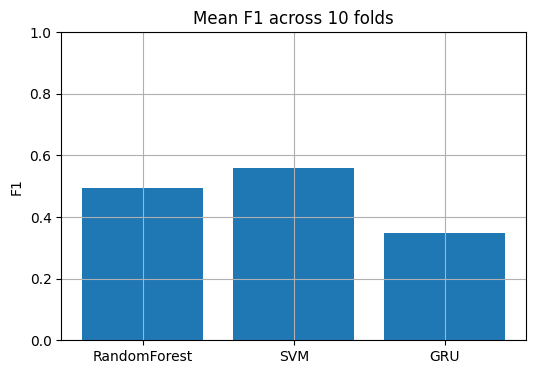

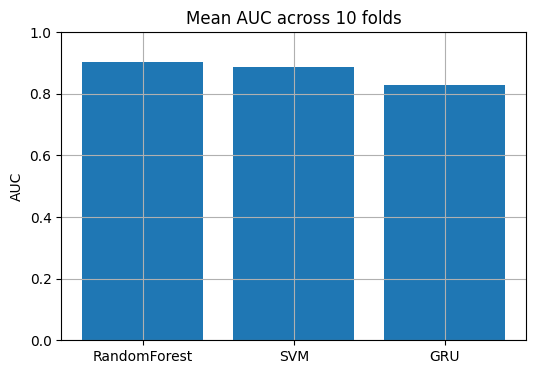

In [46]:
for metric in ["Accuracy", "BalancedAccuracy", "F1", "AUC"]:
    plt.figure()
    plt.bar(summary["Model"], summary[metric])
    plt.title(f"Mean {metric} across 10 folds")
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.show()

## 10. Per-Fold Metrics Tables

The following tables show all required metrics (Accuracy, Balanced Accuracy, Precision, Recall, F1, AUC, BS, BSS, TSS, HSS) for each of the 10 folds, separately for each model, followed by a summary table with the mean values across folds.


In [52]:
from IPython.display import display
import pandas as pd
import os

rf_folds  = pd.read_csv(os.path.join(RESULTS_DIR, "RandomForest_per_fold.csv"))
svm_folds = pd.read_csv(os.path.join(RESULTS_DIR, "SVM_per_fold.csv"))
gru_folds = pd.read_csv(os.path.join(RESULTS_DIR, "GRU_per_fold.csv"))
summary   = pd.read_csv(os.path.join(RESULTS_DIR, "summary_means.csv"))

print("RandomForest – per-fold metrics")
display(rf_folds)

print("SVM – per-fold metrics")
display(svm_folds)

print("GRU – per-fold metrics")
display(gru_folds)

print("Overall summary (mean across folds)")
display(summary)


RandomForest – per-fold metrics


,TP,TN,FP,FN,P,N,TPR,TNR,FPR,FNR,...,Recall,F1,ErrorRate,TSS,HSS,BS,BSS,AUC,Model,Fold
0,6,36,0,2,8,36,0.750000,1.000000,0.000000,0.250000,...,0.750000,0.857143,0.045455,0.750000,0.830769,0.060073,0.596174,0.907986,RandomForest,1
1,0,34,0,4,4,34,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.105263,0.000000,0.000000,0.048253,0.487671,0.985294,RandomForest,2
2,5,30,1,0,5,31,1.000000,0.967742,0.032258,0.000000,...,1.000000,0.909091,0.027778,0.967742,0.892857,0.044696,0.626284,0.987097,RandomForest,3
3,3,28,3,2,5,31,0.600000,0.903226,0.096774,0.400000,...,0.600000,0.545455,0.138889,0.503226,0.464286,0.096186,0.195757,0.890323,RandomForest,4
4,5,29,2,0,5,31,1.000000,0.935484,0.064516,0.000000,...,1.000000,0.833333,0.055556,0.935484,0.801105,0.039251,0.671812,0.987097,RandomForest,5
5,5,28,0,1,6,28,0.833333,1.000000,0.000000,0.166667,...,0.833333,0.909091,0.029412,0.833333,0.891720,0.049921,0.656499,1.000000,RandomForest,6
6,2,23,1,2,4,24,0.500000,0.958333,0.041667,0.500000,...,0.500000,0.571429,0.107143,0.458333,0.511628,0.064082,0.476662,0.958333,RandomForest,7
7,0,23,0,5,5,23,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.178571,0.000000,0.000000,0.107229,0.268975,1.000000,RandomForest,8
8,1,23,0,4,5,23,0.200000,1.000000,0.000000,0.800000,...,0.200000,0.333333,0.142857,0.200000,0.291139,0.065832,0.551197,0.991304,RandomForest,9
9,0,25,0,1,1,25,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.038462,0.000000,0.000000,0.093992,-1.541540,0.320000,RandomForest,10


SVM – per-fold metrics


,TP,TN,FP,FN,P,N,TPR,TNR,FPR,FNR,...,Recall,F1,ErrorRate,TSS,HSS,BS,BSS,AUC,Model,Fold
0,6,36,0,2,8,36,0.75,1.000000,0.000000,0.25,...,0.75,0.857143,0.045455,0.750000,0.830769,0.046906,0.684689,0.934028,SVM,1
1,0,34,0,4,4,34,0.00,1.000000,0.000000,1.00,...,0.00,0.000000,0.105263,0.000000,0.000000,0.091271,0.030920,0.970588,SVM,2
2,5,29,2,0,5,31,1.00,0.935484,0.064516,0.00,...,1.00,0.833333,0.055556,0.935484,0.801105,0.043001,0.640457,0.993548,SVM,3
3,4,28,3,1,5,31,0.80,0.903226,0.096774,0.20,...,0.80,0.666667,0.111111,0.703226,0.602210,0.083328,0.303267,0.941935,SVM,4
4,4,29,2,1,5,31,0.80,0.935484,0.064516,0.20,...,0.80,0.727273,0.083333,0.735484,0.678571,0.042188,0.647252,0.980645,SVM,5
5,6,26,2,0,6,28,1.00,0.928571,0.071429,0.00,...,1.00,0.857143,0.058824,0.928571,0.821053,0.053716,0.630383,1.000000,SVM,6
6,3,23,1,1,4,24,0.75,0.958333,0.041667,0.25,...,0.75,0.750000,0.071429,0.708333,0.708333,0.067369,0.449823,0.968750,SVM,7
7,0,23,0,5,5,23,0.00,1.000000,0.000000,1.00,...,0.00,0.000000,0.178571,0.000000,0.000000,0.166881,-0.137694,0.826087,SVM,8
8,4,23,0,1,5,23,0.80,1.000000,0.000000,0.20,...,0.80,0.888889,0.035714,0.800000,0.867925,0.043531,0.703229,0.991304,SVM,9
9,0,25,0,1,1,25,0.00,1.000000,0.000000,1.00,...,0.00,0.000000,0.038462,0.000000,0.000000,0.040042,-0.082742,0.280000,SVM,10


GRU – per-fold metrics


,TP,TN,FP,FN,P,N,TPR,TNR,FPR,FNR,...,Recall,F1,ErrorRate,TSS,HSS,BS,BSS,AUC,Model,Fold
0,6,18,18,2,8,36,0.750000,0.500000,0.500000,0.250000,...,0.750000,0.375000,0.454545,0.250000,0.140625,0.245638,-0.651234,0.791667,GRU,1
1,0,34,0,4,4,34,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.105263,0.000000,0.000000,0.090645,0.037564,0.654412,GRU,2
2,5,22,9,0,5,31,1.000000,0.709677,0.290323,0.000000,...,1.000000,0.526316,0.250000,0.709677,0.404412,0.120877,-0.010688,0.929032,GRU,3
3,5,21,10,0,5,31,1.000000,0.677419,0.322581,0.000000,...,1.000000,0.500000,0.277778,0.677419,0.368421,0.137698,-0.151336,0.909677,GRU,4
4,2,21,10,3,5,31,0.400000,0.677419,0.322581,0.600000,...,0.400000,0.235294,0.361111,0.077419,0.048780,0.164600,-0.376271,0.729032,GRU,5
5,5,9,19,1,6,28,0.833333,0.321429,0.678571,0.166667,...,0.833333,0.333333,0.588235,0.154762,0.071038,0.393491,-1.707594,0.529762,GRU,6
6,4,15,9,0,4,24,1.000000,0.625000,0.375000,0.000000,...,1.000000,0.470588,0.321429,0.625000,0.322581,0.160202,-0.308313,0.958333,GRU,7
7,5,3,20,0,5,23,1.000000,0.130435,0.869565,0.000000,...,1.000000,0.333333,0.714286,0.130435,0.050847,0.324719,-1.213734,0.843478,GRU,8
8,5,11,12,0,5,23,1.000000,0.478261,0.521739,0.000000,...,1.000000,0.454545,0.428571,0.478261,0.246637,0.227774,-0.552825,0.939130,GRU,9
9,1,19,6,0,1,25,1.000000,0.760000,0.240000,0.000000,...,1.000000,0.250000,0.230769,0.760000,0.195876,0.150457,-3.068366,1.000000,GRU,10


Overall summary (mean across folds)


,TP,TN,FP,FN,P,N,TPR,TNR,FPR,FNR,...,Recall,F1,ErrorRate,TSS,HSS,BS,BSS,AUC,Model,Fold
0,2.7,27.9,0.7,2.1,4.8,28.6,0.488333,0.976478,0.023522,0.511667,...,0.488333,0.495887,0.086938,0.464812,0.468350,0.066952,0.298949,0.902743,RandomForest,0
1,3.2,27.6,1.0,1.6,4.8,28.6,0.590000,0.966110,0.033890,0.410000,...,0.590000,0.558045,0.078372,0.556110,0.530997,0.067823,0.386958,0.888689,SVM,0
2,3.8,17.3,11.3,1.0,4.8,28.6,0.798333,0.587964,0.412036,0.201667,...,0.798333,0.347841,0.373199,0.386297,0.184922,0.201610,-0.800280,0.828452,GRU,0


## 9. ROC Curves for Model Comparison

To complement the averaged metrics and bar-chart comparisons, I also inspected the Receiver Operating Characteristic (ROC) curves for each model.
The ROC curve shows how well the classifier separates positive (moving) vs. negative (stationary) windows across different thresholds.
Models with curves closer to the top-left corner generally perform better.

Since the ROC plots were already generated during the 10-fold cross-validation process in the run_wisdm_cv.py script, I simply loaded the saved images below for Random Forest, SVM, and GRU.

Looking at ROC curves helps confirm whether the high AUC values in the summary table actually reflect good separation between the two classes. The SVM and Random Forest curves stay consistently above the GRU curve, which matches the earlier metric comparison.

ROC Curve: roc_RF_fold2.png


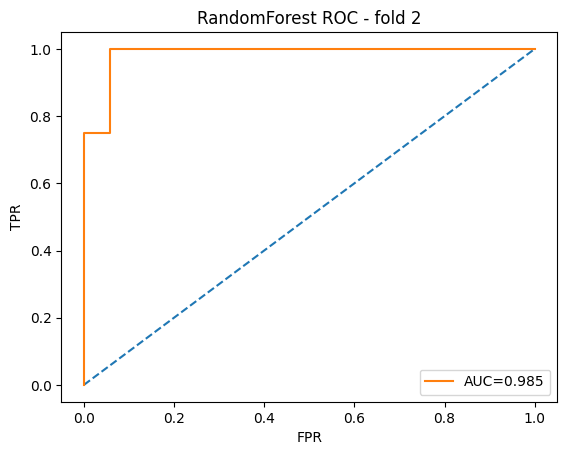

ROC Curve: roc_SVM_fold2.png


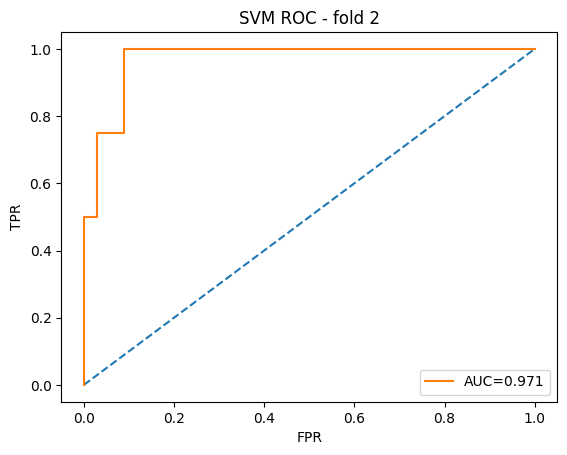

ROC Curve: roc_GRU_fold2.png


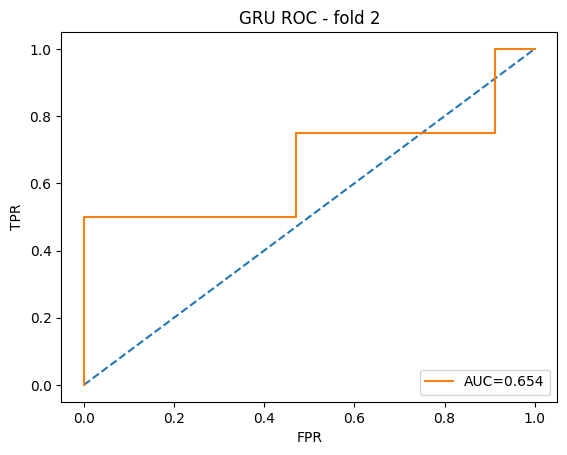

In [47]:
from IPython.display import Image, display
import os

roc_files = [
    "roc_RF_fold2.png",
    "roc_SVM_fold2.png",
    "roc_GRU_fold2.png"
]

for fname in roc_files:
    path = os.path.join(RESULTS_DIR, fname)
    if os.path.exists(path):
        print(f"ROC Curve: {fname}")
        display(Image(filename=path))
    else:
        print(f"File not found: {fname}")


- **Random Forest** and **SVM** show steep curves near the top-left,
  indicating strong separability (AUC ~ 0.97-0.99).
- **GRU** has a noticeably flatter curve (AUC ~ 0.65), confirming that the
  recurrent model performs worse on this small, downsampled dataset.

To make sure this behaviour is not unique to fold 2, the next section shows
**AUC across all folds**, confirming that Random Forest and SVM consistently
outperform GRU on every user.

## 11. AUC Across All 10 Folds

To avoid showing 10 separate ROC curves per model, the figure below plots the AUC value for each fold for all three models. This provides a compact yet complete cross-validated view of ROC performance.

In [51]:
# AUC per fold for each model

# Load the per-fold results that were saved by run_wisdm_cv.py
rf_folds  = pd.read_csv(os.path.join(RESULTS_DIR, "RandomForest_per_fold.csv"))
svm_folds = pd.read_csv(os.path.join(RESULTS_DIR, "SVM_per_fold.csv"))
gru_folds = pd.read_csv(os.path.join(RESULTS_DIR, "GRU_per_fold.csv"))

# small table: rows = folds, columns = models
auc_by_fold = pd.DataFrame({
    "Fold": rf_folds["Fold"],          # 1..10
    "RandomForest": rf_folds["AUC"],
    "SVM":          svm_folds["AUC"],
    "GRU":          gru_folds["AUC"],
})

# In case any fold has only one class and produced NaN value of AUC, we can drop those rows
auc_by_fold = auc_by_fold.dropna()

auc_by_fold


,Fold,RandomForest,SVM,GRU
0,1,0.907986,0.934028,0.791667
1,2,0.985294,0.970588,0.654412
2,3,0.987097,0.993548,0.929032
3,4,0.890323,0.941935,0.909677
4,5,0.987097,0.980645,0.729032
5,6,1.000000,1.000000,0.529762
6,7,0.958333,0.968750,0.958333
7,8,1.000000,0.826087,0.843478
8,9,0.991304,0.991304,0.939130
9,10,0.320000,0.280000,1.000000


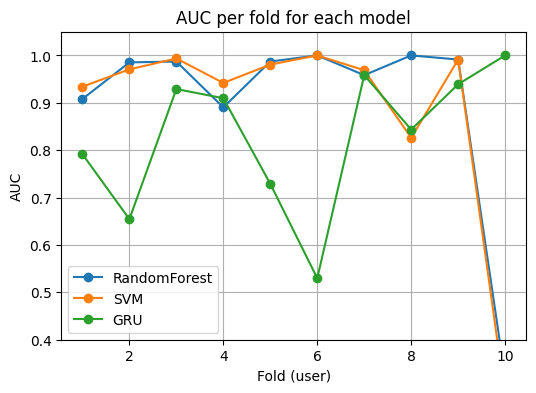

In [49]:
import matplotlib.pyplot as plt

plt.figure()
for model in ["RandomForest", "SVM", "GRU"]:
    plt.plot(auc_by_fold["Fold"],
             auc_by_fold[model],
             marker="o",
             label=model)

plt.xlabel("Fold (user)")
plt.ylabel("AUC")
plt.title("AUC per fold for each model")
plt.ylim(0.4, 1.05)  
plt.legend()
plt.grid(True)
plt.show()


## Observations: 

- **Random Forest** shows very stable performance across folds, with AUC
  typically between 0.90 and 1.00.
- **SVM** behaves similarly, also consistently achieving high AUC values.
- **GRU** has the lowest and most unstable AUC, with some folds dropping to
  around 0.50, which is close to random guessing.

These trends match the fold-2 ROC curves shown earlier and reinforce the
conclusion that **Random Forest and SVM are the strongest models**, while
the GRU struggles due to limited dataset size and class imbalance.

## 12. Confusion Matrices

To complement the per-fold metrics and ROC curves, I also visualized the confusion matrices for each model.  

Since the evaluation script already saves TP, TN, FP, FN for every fold in the per-fold CSV files, I aggregated these counts across all 10 folds to obtain an overall confusion matrix per model:

- **TN** (True Negatives): correctly predicted negative class  
- **FP** (False Positives): negative windows predicted as positive  
- **FN** (False Negatives): positive windows predicted as negative  
- **TP** (True Positives): correctly predicted positive class  

The matrices below show the total counts summed over all folds for:

- Random Forest  
- SVM (RBF)  
- GRU  

This gives a compact view of how often each model confuses the two classes over the entire cross-validation procedure.


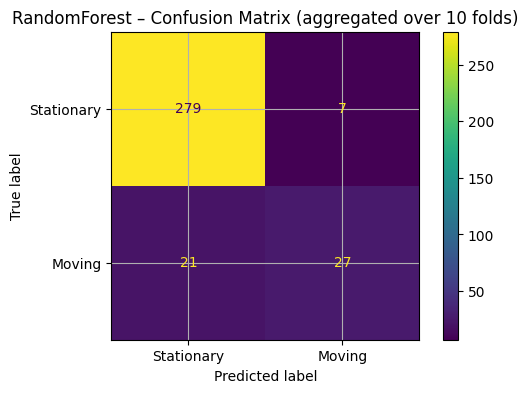

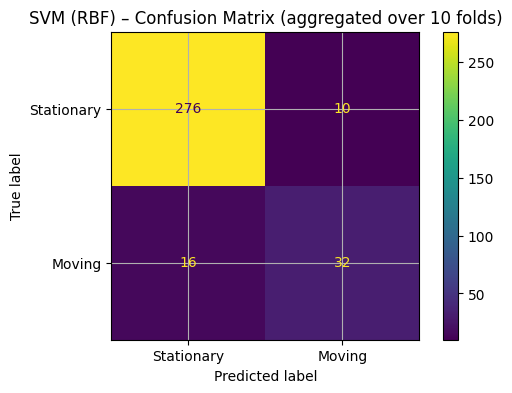

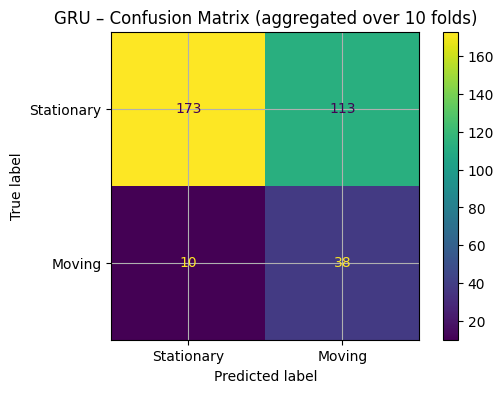

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Directory where the per-fold CSVs are stored
RESULTS_DIR = os.path.join("results")

# Map model names to their per-fold CSV files
model_files = {
    "RandomForest": "RandomForest_per_fold.csv",
    "SVM (RBF)": "SVM_per_fold.csv",
    "GRU": "GRU_per_fold.csv",
}


class_labels = ["Stationary", "Moving"] 

for model_name, filename in model_files.items():
    csv_path = os.path.join(RESULTS_DIR, filename)
    df = pd.read_csv(csv_path)

    # Sum confusion-matrix counts across all 10 folds
    totals = df[["TP", "TN", "FP", "FN"]].sum()

    tn = int(totals["TN"])
    fp = int(totals["FP"])
    fn = int(totals["FN"])
    tp = int(totals["TP"])

    # Build 2x2 confusion matrix: rows = true, cols = predicted
    cm = np.array([[tn, fp],
                   [fn, tp]])

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_labels)
    disp.plot(ax=ax, values_format="d")
    ax.set_title(f"{model_name} – Confusion Matrix (aggregated over 10 folds)")
    plt.show()


### Observations

- SVM (RBF) performs best, correctly identifying more Moving windows and having the lowest false-negative rate.

- Random Forest performs well on the majority Stationary class but misses several Moving windows.

- GRU shows the weakest performance, with many false positives and difficulty separating the two classes.

Overall, **SVM provides the most balanced performance**, while GRU struggles due to limited temporal information and data size.